In [1]:
import numpy as np
from scipy import optimize
import copy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
class Flow:
  def __init__(self, name: str,
               volume_flow_rate: float,
               molar_fractions: np.ndarray,
               mole_weights: np.ndarray,
               ) -> None:
    self.name = name
    self.volume_flow_rate = volume_flow_rate
    self.molar_fractions = molar_fractions
    self.n_comps = len(self.molar_fractions)
    self.mole_weights = mole_weights
    self.calc_flow_density()
    self.convert_molar_to_mass_fractions()
    self.mass_flow_rate = self.volume_flow_rate * 3600 / 1000 * self.density
    self.convert_mass_to_mole_fractions()
    self.mole_flow_rate = self.molar_fractions.sum() * self.volume_flow_rate

    self.calc_average_molar_mass()

  def calc_flow_density(self) -> None:
    self.density = (self.molar_fractions * self.mole_weights).sum()

  def convert_molar_to_mass_fractions(self) -> None:
    self.mass_fractions = (self.molar_fractions * self.mole_weights) /\
    (self.molar_fractions * self.mole_weights).sum()

  def convert_mass_to_mole_fractions(self) -> None:
    x = self.mass_fractions / self.mole_weights
    s = x.sum()
    self.mole_fractions = x / s

  def calc_average_molar_mass(self) -> None:
    self.mole_mass = (self.mass_fractions / self.mole_weights).sum() ** (-1)

  def describe(self) -> None:
    print(f'Имя потока: {self.name}')
    print(f'Массовый расход = {self.mass_flow_rate:1.1f} кг/ч')
    print(f'Объемный расход = {self.volume_flow_rate:1.1f} л/с')
    print(f'Мольный расход = {self.mole_flow_rate:1.1f} моль/с')
    print(f'Плотность = {self.density:1.1f} кг/м3')
    print('Массовые доли:')
    for i in range(self.n_comps):
      print(f'{self.mass_fractions[i]:1.3f} кг/кг')
    print(20 * '-')

class Reactor():
  def __init__(self, volume: float) -> None:
    self.volume = volume

  def calculate(self, prod_name: str,
                kinetic_equations: Callable,
                feedstock: Flow, args: tuple = (),
                n: int = 1000) -> None:
    self.feedstock = feedstock
    self.residence__time = self.volume / self.feedstock.volume_flow_rate
    self.time = np.linspace(0, self.residence__time, n)

    self.solution = solve_ivp(fun=kinetic_equations,
            t_span=(0, self.residence__time), y0=self.feedstock.molar_fractions,
            t_eval=self.time, args=args)

    self.product = Flow(name=prod_name,
            volume_flow_rate=self.feedstock.volume_flow_rate,
            molar_fractions=self.solution.y[:, -1],
            mole_weights=self.feedstock.mole_weights)

    return self.product

class ComponentSplitter():
  def splitflows(self, flow: Flow, names: list[str],
                 ratios: np.ndarray,
                 comp_densities: np.ndarray) -> list[Flow]:
    n_new_flows = len(ratios)
    flow.n_comps
    check_list = np.sum(ratios, axis=0)
    new_flows = []
    for i in range(n_new_flows):
      if check_list[i] >= 1:
        raise Exception(f"Попытка извлечь больше 100% компонента {i}")

    ratios = np.concatenate((ratios,
      np.expand_dims(np.ones(flow.n_comps) - np.sum(ratios, axis=0), axis=0)))
    n_new_flows = len(ratios)

    new_mass_flows = flow.mass_flow_rate * flow.mass_fractions * ratios
    new_mass_fractions = np.multiply(new_mass_flows,
              np.expand_dims(1/np.sum(new_mass_flows, axis=1), axis=1))
    volume_flows = np.sum((new_mass_flows / comp_densities * 1000 / 3600), axis=1)
    mole_flows = new_mass_flows / flow.mole_weights * 1000 / 3600
    mole_fractions = mole_flows / np.expand_dims(volume_flows, axis=1)

    for i in range(n_new_flows):
      new_flows.append(Flow(name=names[i],
                            volume_flow_rate=volume_flows[i],
                            molar_fractions=mole_fractions[i],
                            mole_weights=flow.mole_weights))
    return new_flows

In [3]:
def equations(t: float, c: np.ndarray, k: np.ndarray) -> np.ndarray:
  cC6H12, nC6H12, C6H6, H2 = c
  k1, k2, k3 = k

  r1 = k1 * cC6H12
  r2 = k2 * cC6H12 * H2
  r3 = k3 * nC6H12

  dcC6H12_dt = -r1 - r2 + r3
  dnC6H12_dt = r2 - r3
  dC6H6_dt = r1
  dH2_dt = 3 * r1 - r2 + r3

  return np.array([dcC6H12_dt, dnC6H12_dt, dC6H6_dt, dH2_dt])

feedstock = Flow(name = 'feedstock',
            volume_flow_rate=10,
            molar_fractions=np.array([0.8, 0.2, 0.0, 0.0]),
            mole_weights=np.array([84, 86, 78, 2]))

v1 = 15
v2 = 1.85 * v1
k = np.array([0.4, 0.05, 0.25])

r1 = Reactor(v1)
r2_1 = Reactor(v2)
r2_2 = Reactor(v2)
spl1 = ComponentSplitter()

prod1 = r1.calculate(prod_name='prod1',
             kinetic_equations=equations,
             feedstock=feedstock, args=(k, ))

prod2_1 = r2_1.calculate(prod_name='prod2-1',
             kinetic_equations=equations,
             feedstock=prod1, args=(k, ))

benz_h2, feed_after_spliter = spl1.splitflows(flow=prod1,
          names=['benz_h2', 'feed_after_spliter'],
          ratios=np.array([[0.0, 0.0, 1.0, 1.0]]),
          comp_densities=np.array([777.67, 662.37, 882.20, 8.57E-1]))

prod2_2 = r2_2.calculate(prod_name='prod2-2',
             kinetic_equations=equations,
             feedstock=feed_after_spliter, args=(k, ))

flows = [feedstock, prod1, prod2_1, benz_h2, feed_after_spliter, prod2_2]
for flow in flows:
  flow.describe()

Имя потока: feedstock
Массовый расход = 3038.4 кг/ч
Объемный расход = 10.0 л/с
Мольный расход = 10.0 моль/с
Плотность = 84.4 кг/м3
Массовые доли:
0.796 кг/кг
0.204 кг/кг
0.000 кг/кг
0.000 кг/кг
--------------------
Имя потока: prod1
Массовый расход = 3038.4 кг/ч
Объемный расход = 10.0 л/с
Мольный расход = 21.6 моль/с
Плотность = 84.4 кг/м3
Массовые доли:
0.464 кг/кг
0.164 кг/кг
0.344 кг/кг
0.027 кг/кг
--------------------
Имя потока: prod2-1
Массовый расход = 3038.4 кг/ч
Объемный расход = 10.0 л/с
Мольный расход = 31.7 моль/с
Плотность = 84.4 кг/м3
Массовые доли:
0.173 кг/кг
0.130 кг/кг
0.645 кг/кг
0.051 кг/кг
--------------------
Имя потока: benz_h2
Массовый расход = 1129.4 кг/ч
Объемный расход = 27.3 л/с
Мольный расход = 15.3 моль/с
Плотность = 11.5 кг/м3
Массовые доли:
0.000 кг/кг
0.000 кг/кг
0.926 кг/кг
0.074 кг/кг
--------------------
Имя потока: feed_after_spliter
Массовый расход = 1909.0 кг/ч
Объемный расход = 0.7 л/с
Мольный расход = 6.3 моль/с
Плотность = 743.9 кг/м3
Массовые 

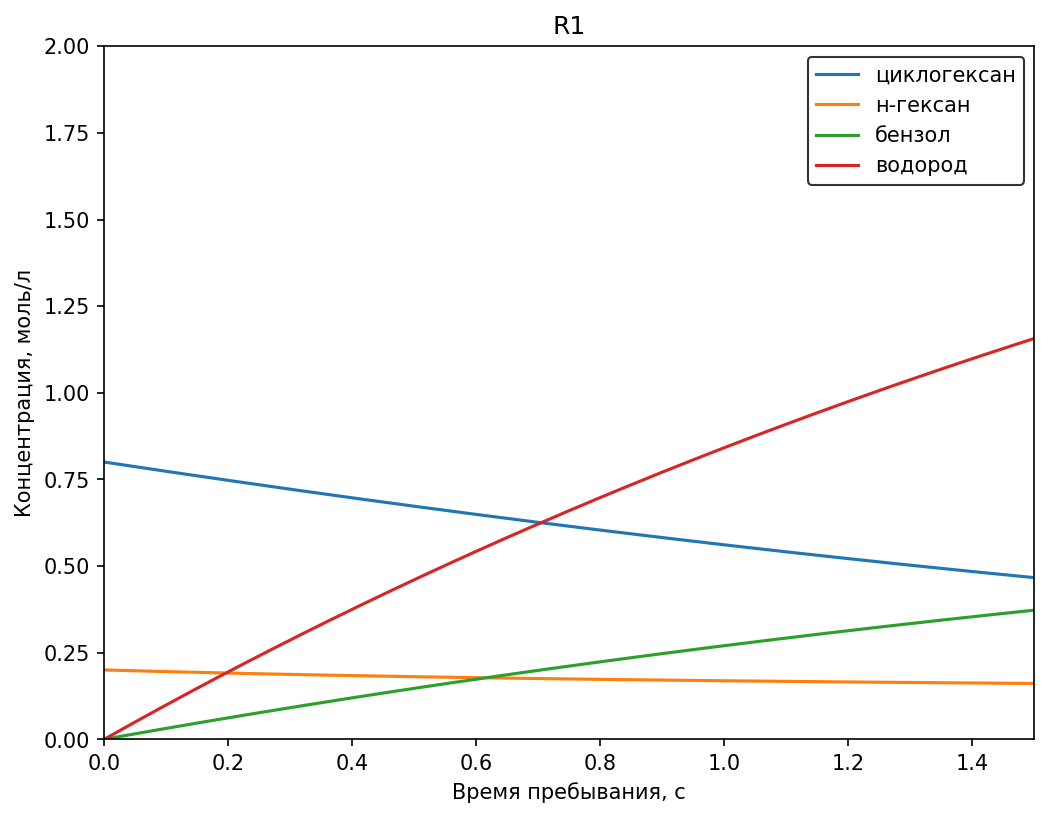

In [4]:
fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(xlim=[0, r1.residence__time], ylim=[0, 2])
ax.plot(r1.time, r1.solution.y[0], label='циклогексан')
ax.plot(r1.time, r1.solution.y[1], label='н-гексан')
ax.plot(r1.time, r1.solution.y[2], label='бензол')
ax.plot(r1.time, r1.solution.y[3], label='водород')
ax.legend(frameon=True, edgecolor='black')
ax.set_title('R1')
ax.set_xlabel('Время пребывания, с')
ax.set_ylabel('Концентрация, моль/л');

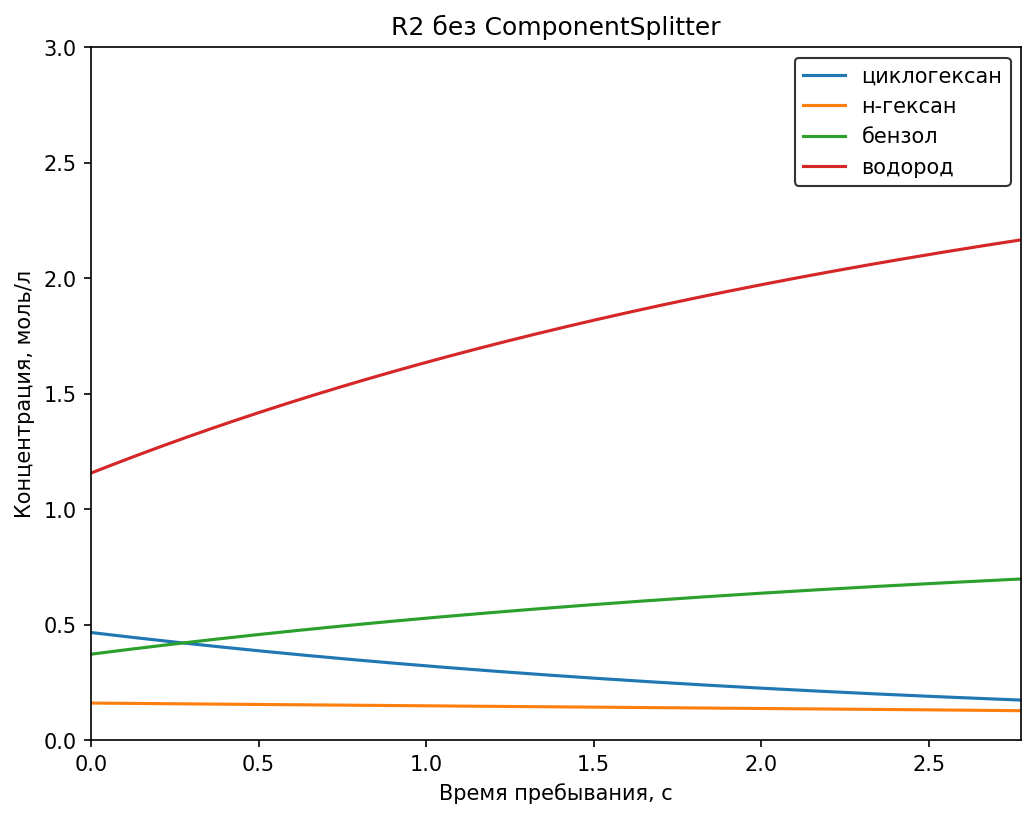

In [5]:
fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(xlim=[0, r2_1.residence__time], ylim=[0, 3])
ax.plot(r2_1.time, r2_1.solution.y[0], label='циклогексан')
ax.plot(r2_1.time, r2_1.solution.y[1], label='н-гексан')
ax.plot(r2_1.time, r2_1.solution.y[2], label='бензол')
ax.plot(r2_1.time, r2_1.solution.y[3], label='водород')
ax.legend(frameon=True, edgecolor='black')
ax.set_title('R2 без ComponentSplitter')
ax.set_xlabel('Время пребывания, с')
ax.set_ylabel('Концентрация, моль/л');

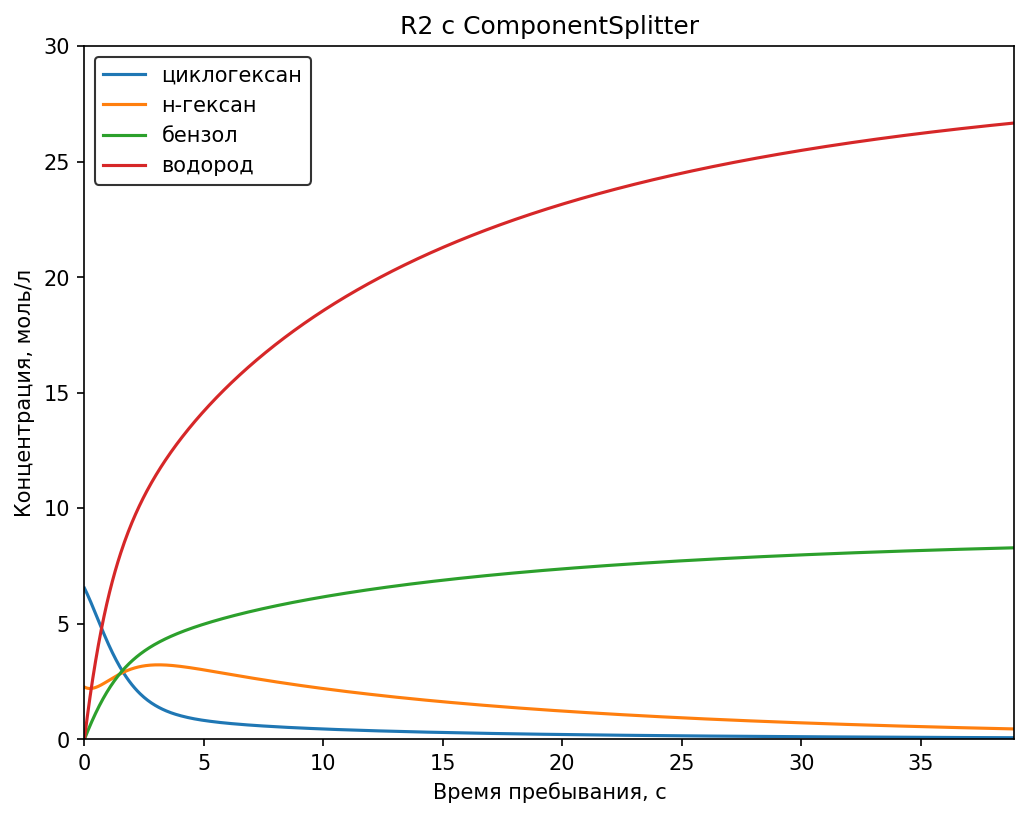

In [6]:
fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(xlim=[0, r2_2.residence__time], ylim=[0, 30])
ax.plot(r2_2.time, r2_2.solution.y[0], label='циклогексан')
ax.plot(r2_2.time, r2_2.solution.y[1], label='н-гексан')
ax.plot(r2_2.time, r2_2.solution.y[2], label='бензол')
ax.plot(r2_2.time, r2_2.solution.y[3], label='водород')
ax.legend(frameon=True, edgecolor='black')
ax.set_title('R2 с ComponentSplitter')
ax.set_xlabel('Время пребывания, с')
ax.set_ylabel('Концентрация, моль/л');